# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [ ]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [ ]:
portfolio.head()

In [ ]:
profile.head()
# 118 for age is the coding for N/A

In [ ]:
transcript.head()

# Assess Data

We already know 118 is an encoded age for missing values. We can change this to np.nan.
Explore data to determine other quality issues.

In [ ]:
portfolio.info()

In [ ]:
# May as well look at the whole thing since it's small
portfolio

In [ ]:
portfolio.channels

One thing to note is that duration in this dataset is in days, and time in the transcript is in hours. We'll have to equate these at some point, so may as well change duration here to hours.

In [8]:
portfolio_clean = portfolio.copy()

In [9]:
portfolio_clean.duration = portfolio_clean.duration*24 # days to hours

In [10]:
portfolio_clean['id_short'] = portfolio_clean.id.str[:4]

In [11]:
portfolio_clean

,reward,channels,difficulty,duration,offer_type,id,id_short
0,10,"[email, mobile, social]",10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,ae26
1,10,"[web, email, mobile, social]",10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,4d5c
2,0,"[web, email, mobile]",0,96,informational,3f207df678b143eea3cee63160fa8bed,3f20
3,5,"[web, email, mobile]",5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98
4,5,"[web, email]",20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e
5,3,"[web, email, mobile, social]",7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,2298
6,2,"[web, email, mobile, social]",10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,fafd
7,0,"[email, mobile, social]",0,72,informational,5a8bc65990b245e5a138643cd4eb9837,5a8b
8,5,"[web, email, mobile, social]",5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,f194
9,2,"[web, email, mobile]",10,168,discount,2906b810c7d4411798c6938adc9daaa5,2906


Portfolio seems clean, though we might have to encode the channels into their own columns at some point.
There's only 10 different offers.
The different channels are web, email, mobile, and social. Each offer is sent through 2+ channels.
There are 3 types of offers - BOGO, discount, and informational.

In [12]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [13]:
sum(profile.id.duplicated())

0

In [14]:
profile.age.describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [15]:
profile.became_member_on.describe()

count    1.700000e+04
mean     2.016703e+07
std      1.167750e+04
min      2.013073e+07
25%      2.016053e+07
50%      2.017080e+07
75%      2.017123e+07
max      2.018073e+07
Name: became_member_on, dtype: float64

In [16]:
profile.gender.describe()
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [17]:
np.sum(profile.gender.isnull())
sum(profile[profile.gender.isnull()].age!=118)
sum(~profile[profile.gender.isnull()].income.isnull())

0

The rows for which age is encoded as 118, gender is null, and income is null are the same. That's a lot of demographic values that we're missing for those customers. Since it's only 2,175 customers out of 17,000 (a small percentage), and we're missing all 3 values for these customers, I think it's best to just drop these rows.
Therefore, we should also drop the corresponding users in the transcript dataset.

In [18]:
profile_clean = profile.copy()

In [19]:
users_wo_info = list(profile_clean[profile_clean.age == 118].id)

In [20]:
profile_clean = profile_clean[profile_clean.age != 118]
profile_clean.shape

(14825, 5)

In [21]:
profile_clean.income.describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [22]:
profile_clean.age.describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

So, There's 14,825 unique customers on the app that we're keeping in the dataset.
The column values seem reasonable, or at least plausible.

Add some columns for further analysis.

In [23]:
profile_clean['membership_year'] = profile_clean['became_member_on'].astype(str).str[:4]
# convert from string to numeric
profile_clean['membership_year'] = profile_clean['membership_year'].astype(int)

profile_clean['age_binned'] = pd.cut(profile_clean.age, [profile_clean.age.min(),39,64,profile_clean.age.max()], include_lowest=True,labels=['young adult','middle aged','senior citizen'])

profile_clean['income_binned'] = pd.cut(profile_clean.income, [30000,49999,99999,120000], include_lowest=True, labels=['<$50k','<$100k','>=$100k'])

In [24]:
profile_clean.head()

,gender,age,id,became_member_on,income,membership_year,age_binned,income_binned
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017,middle aged,>=$100k
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017,senior citizen,>=$100k
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,2018,senior citizen,<$100k
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,2018,senior citizen,<$100k
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,2017,middle aged,<$100k


In [25]:
profile_clean.id.describe()

count                                14825
unique                               14825
top       ba6acc5c02514f74a5838f92f70a9684
freq                                     1
Name: id, dtype: object

In [26]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
person    306534 non-null object
event     306534 non-null object
value     306534 non-null object
time      306534 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [27]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [28]:
transcript.person.describe()

count                               306534
unique                               17000
top       94de646f7b6041228ca7dec82adb97d2
freq                                    51
Name: person, dtype: object

In [29]:
# looking at the user with the most events in the transcript to get a better idea of how the offer process looks
transcript[transcript.person=='94de646f7b6041228ca7dec82adb97d2']

,person,event,value,time
2276,94de646f7b6041228ca7dec82adb97d2,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
16010,94de646f7b6041228ca7dec82adb97d2,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},6
24531,94de646f7b6041228ca7dec82adb97d2,transaction,{'amount': 7.41},30
24532,94de646f7b6041228ca7dec82adb97d2,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,30
42252,94de646f7b6041228ca7dec82adb97d2,transaction,{'amount': 1.47},102
55475,94de646f7b6041228ca7dec82adb97d2,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},168
75256,94de646f7b6041228ca7dec82adb97d2,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},186
77624,94de646f7b6041228ca7dec82adb97d2,transaction,{'amount': 2.62},192
81725,94de646f7b6041228ca7dec82adb97d2,transaction,{'amount': 0.59},204
93913,94de646f7b6041228ca7dec82adb97d2,transaction,{'amount': 2.2800000000000002},246


In [30]:
# As mentioned before, delete transactions for users with missing info in profile datasest

transcript_clean = transcript.copy()
transcript_clean = transcript_clean[~transcript_clean.person.isin(users_wo_info)]
transcript_clean.shape

(272762, 4)

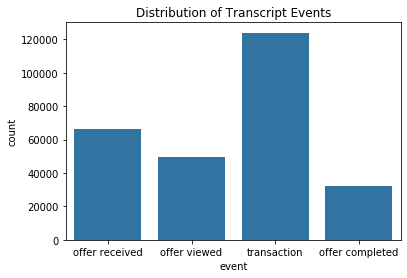

In [143]:
transcript_clean.event.value_counts()
base_color = sb.color_palette()[0]
sb.countplot(data = transcript_clean, x = 'event', color=base_color);
plt.title('Distribution of Transcript Events');

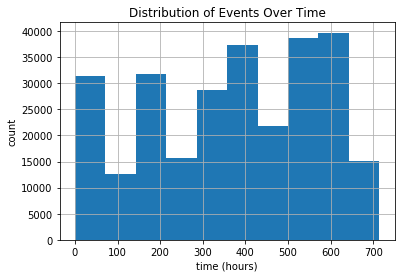

In [145]:
transcript_clean.hist(column='time');
plt.title('Distribution of Events Over Time');
plt.xlabel('time (hours)');
plt.ylabel('count');

In [33]:
transcript_clean.person.describe()

count                               272762
unique                               14825
top       94de646f7b6041228ca7dec82adb97d2
freq                                    51
Name: person, dtype: object

In [34]:
transcript.shape

(306534, 4)

In [35]:
transcript_clean.time.describe()

count    272762.000000
mean        366.707694
std         200.359087
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [36]:
transcript_clean.value.describe()

count                                               272762
unique                                                5054
top       {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
freq                                                 13059
Name: value, dtype: object

We should change the format of the last value column of the transcript dataframe. It's a dictionary with one term per row, but the key corresponds to the event column. Therefore, it's redundant, and makes the value of the dictionary (which is the relevant part) harder to process. To be safe, we should verify that this is in fact the case by splitting up the key and value of the dictionary into different columns and comparing the key column to the event column.

In [37]:
get_key = lambda d: list(d.keys())[0]
transcript_clean['value_key'] = transcript_clean['value'].apply(get_key)

get_value = lambda d: list(d.values())[0]
transcript_clean['value_value'] = transcript_clean['value'].apply(get_value)

In [38]:
transcript_clean.head()

,person,event,value,time,value_key,value_value
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,offer id,2906b810c7d4411798c6938adc9daaa5
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,offer id,f19421c1d4aa40978ebb69ca19b0e20d
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,offer id,3f207df678b143eea3cee63160fa8bed
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [39]:
# The following is testing that the value column corresponds to the event column.
# Commented out after check because it takes a long time to run

# for i in range(transcript_clean.shape[0]):
#     if transcript_clean.iloc[i].event=='offer received' or transcript_clean.iloc[i].event=='offer viewed' or transcript_clean.iloc[i].event=='offer completed':
# #         assert(transcript_clean.iloc[i].value_key=='offer id')
#         if transcript_clean.iloc[i].value_key!='offer id' and transcript_clean.iloc[i].value_key!='offer_id':
#             print(i)
#             break
#     elif transcript_clean.iloc[i].event=='transaction':
#         if transcript_clean.iloc[i].value_key!='amount':
#             print(i)
#             break
#     else:
#         print('ERROR!!!')
# print('Done')

So the values in 'value' column correspond to the event column. We can drop the value and value_key columns, then rename value_value column back to value.

In [40]:
transcript_clean.drop(['value','value_key'],axis=1,inplace=True)
transcript_clean.rename(columns={"value_value": "value"},inplace=True)
transcript_clean.head()

,person,event,time,value
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
5,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7


Prepare dataset for analysis by subsetting to transactions where offers have been completed

In [42]:
offers_effect = transcript_clean[(transcript_clean.event=='offer received')]

In [43]:
from IPython.core.debugger import set_trace

portfolio_sub = portfolio_clean[['id','duration']]
duration_dict = pd.Series(portfolio_sub.duration.values,index=portfolio_sub.id).to_dict()

portfolio_sub2 = portfolio_clean[['id','offer_type']]
type_dict = pd.Series(portfolio_sub2.offer_type.values,index=portfolio_sub2.id).to_dict()

transcript_offer_completed = transcript_clean[transcript_clean.event=="offer completed"]
transcript_offer_viewed = transcript_clean[transcript_clean.event=="offer viewed"]
transcript_transaction = transcript_clean[transcript_clean.event=="transaction"]

transcript_transaction['influenced'] = np.nan # Assume all transactions are not influenced and change certain ones to 1 in loop below

def determine_influence(row):
    # return 0 if not completed, 1 if completed accidentally (offer not viewed), and 2 if offer was influential (offer viewed)
    
    # Here, I'm assuming that the offer is valid from the date it was received for both offers
    # (even though a customer would not be "feeling an effect" of an informational ad
    # before they've viewed it, and info ads don't have an expiration date of usage technically)
    offer_id = row.value
    time_received = row.time
    time_exp = time_received+duration_dict[offer_id]
    if type_dict[offer_id]!='informational': # might have to make sure we can index with a value not in keys
        # find date that offer was received
#         corresponding_offer_received = transcript_offer_received[(transcript_offer_received.person==row.person) & # same customer
#                                                                  (transcript_offer_received.value==offer_id) & # same offer
#                                                                  (transcript_offer_received.time<=row.time)] # received not after it was viewed
        # In case there's more than one received offer that matches the above conditions, take the later one
#         date_received = corresponding_offer_received.iloc[-1].time
#         date_received = row.time
        
        corresponding_offer_completed = transcript_offer_completed[(transcript_offer_completed.person==row.person) & # same customer
                                                                   (transcript_offer_completed.value==offer_id) &  # same offer
                                                                   # offer completed within the offer's duration
                                                                   (transcript_offer_completed.time>=time_received) &
                                                                   (transcript_offer_completed.time<=(time_exp))]
        
        # I think we can assume that corresponding_offer_completed will only be one row, meaning that the same offer isn't
        # offered again before the first one expires
        try:
            time_completed = corresponding_offer_completed.iloc[0].time # **CHECK WHY THIS WOULD BE MORE THAN ONE ROW**
        except IndexError:
            time_completed = np.inf
        
        # Find if offer viewed before completing offer (same as not viewing at all)
        corresponding_offer_viewed = transcript_offer_viewed[(transcript_offer_viewed.person==row.person) & # same customer
                                                             (transcript_offer_viewed.value==offer_id) & # same offer
                                                             (transcript_offer_viewed.time>=row.time) & # received not after it was viewed
                                                             (transcript_offer_viewed.time<=time_completed) & # viewed before completed
                                                             (transcript_offer_viewed.time<=(time_exp))] # viewed before offer expiry
        
        try:
            time_viewed = corresponding_offer_viewed.time.iloc[0]
        except IndexError:
            time_viewed = np.inf
#         set_trace()
        idx_influenced = transcript_transaction.index[(transcript_transaction.person==row.person) & # same person
#                                                       (transcript_transaction.value==offer_id) & # same offer - wrong; can't know this
                                                      (transcript_transaction.time>=time_viewed) & # transaction after viewing
                                                      (transcript_transaction.time<=time_completed) & # transaction before completion
                                                      (transcript_transaction.time<=time_exp)] # within offer's duration
        transcript_transaction.loc[idx_influenced,'influenced'] = offer_id
        
    else: # if offer is informational                                                     
#         date_viewed = corresponding_offer_viewed.time
        
        corresponding_offer_completed = transcript_transaction[(transcript_transaction.person==row.person) & # same customer
                                                                # offer completed within the ad's influencial period
                                                                (transcript_transaction.time>=time_received) &
                                                                (transcript_transaction.time<=(time_exp))]
        # Here I'm assuming more than one transaction can be made after receiving the ad and before its expiry,
        # but just take the first purchase as "completing" the offer
        try:
            time_completed = corresponding_offer_completed.iloc[0].time
        except IndexError:
            time_completed = np.inf
            
        # Viewing it only counts if done before completing the offer
        corresponding_offer_viewed = transcript_offer_viewed[(transcript_offer_viewed.person==row.person) & # same customer
                                                             (transcript_offer_viewed.value==offer_id) & # same offer
                                                             (transcript_offer_viewed.time>=time_received) & # received not after it was viewed
                                                             (transcript_offer_viewed.time<=time_completed)] # viewed before transaction
        
        try:
            time_viewed = corresponding_offer_viewed.time.iloc[0]
        except IndexError:
            time_viewed = np.inf
        idx_influenced = transcript_transaction.index[(transcript_transaction.person==row.person) & # same person
#                                                       (transcript_transaction.value==offer_id) & # same offer - we can't know this; this is wrong
                                                      (transcript_transaction.time>=time_viewed) & # transaction after viewing
                                                      (transcript_transaction.time<=time_exp)] # within offer's duration
        transcript_transaction.loc[idx_influenced,'influenced'] = offer_id
    
    # Now, if corresponding_offer_completed is not empty, then we have 'completed' the offer
    if corresponding_offer_completed.shape[0]>=1 & corresponding_offer_viewed.shape[0]>=1:
        return 'completed deliberately'
    elif corresponding_offer_completed.shape[0]>=1:
        return 'completed unwittingly'
    elif corresponding_offer_viewed.shape[0]>=1:
        return 'viewed/uncompleted'
    else:
        return 'unviewed'                                              

offers_effect['completed'] = offers_effect.apply(determine_influence, axis=1) # send each whole row to determine_influence

C:\Users\dagus\Anaconda3\envs\udacity\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\dagus\Anaconda3\envs\udacity\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\dagus\Anaconda3\envs\udacity\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [44]:
offers_effect.to_pickle('offers_effect.pkl')
transcript_transaction.to_pickle('transcript_transaction.pkl')

In [ ]:
# offers_effect = pd.read_pickle('offers_effect.pkl')
# transcript_transaction = pd.read_pickle('transcript_transaction.pkl')

In [ ]:
# DELETE LATER
# offers_effect['completed'] = offers_effect['completed'].replace([0,0.5,1,2], ['unviewed','viewed/uncompleted','completed unwittingly','completed deliberately'])

In [45]:
offers_effect.sample(5)

,person,event,time,value,completed
9521,4d0142b1561949a289acbcf0245cbbc6,offer received,0,3f207df678b143eea3cee63160fa8bed,completed unwittingly
154733,d2e88e95c0ae41c0980e4cfc10d162d8,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,viewed/uncompleted
256199,86dd79d82f244f10ba7e7b92e567af14,offer received,576,fafdcd668e3743c1bb461111dcafc2a4,completed deliberately
57191,147342333fb24de68e8e7a3ee22b267c,offer received,168,0b1e1539f2cc45b7b9fa7c272da2e1d7,viewed/uncompleted
113732,f883a0574d944b0488bca8cc4b22a728,offer received,336,fafdcd668e3743c1bb461111dcafc2a4,completed deliberately


Some thoughts and assumptions about the informational offer:
- It's hard to say an informational offer is "completed" since a transaction could be an influence from a previous offer (however if offers don't overlap in time, then this is not an issue. On the other hand, an informational offer can be viewed much later than it was received and still a transaction after that would count, which could be in the timeframe of another offer)
- I'll just say that this type of offer can be "completed" only if it's viewed and a transaction is made within the influencial period of the ad from the time of RECEIVING it

In [46]:
offers_effect.head(20)

,person,event,time,value,completed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,completed deliberately
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,viewed/uncompleted
5,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,completed deliberately
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,unviewed
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,viewed/uncompleted
9,31dda685af34476cad5bc968bdb01c53,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,viewed/uncompleted
12,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,ae264e3637204a6fb9bb56bc8210ddfd,viewed/uncompleted
13,c27e0d6ab72c455a8bb66d980963de60,offer received,0,3f207df678b143eea3cee63160fa8bed,completed deliberately
14,d53717f5400c4e84affdaeda9dd926b3,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,completed deliberately
15,f806632c011441378d4646567f357a21,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,completed deliberately


In [47]:
portfolio_clean

,reward,channels,difficulty,duration,offer_type,id,id_short
0,10,"[email, mobile, social]",10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,ae26
1,10,"[web, email, mobile, social]",10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,4d5c
2,0,"[web, email, mobile]",0,96,informational,3f207df678b143eea3cee63160fa8bed,3f20
3,5,"[web, email, mobile]",5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98
4,5,"[web, email]",20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e
5,3,"[web, email, mobile, social]",7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,2298
6,2,"[web, email, mobile, social]",10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,fafd
7,0,"[email, mobile, social]",0,72,informational,5a8bc65990b245e5a138643cd4eb9837,5a8b
8,5,"[web, email, mobile, social]",5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,f194
9,2,"[web, email, mobile]",10,168,discount,2906b810c7d4411798c6938adc9daaa5,2906


In [48]:
offers_effect.drop('event',axis=1,inplace=True)

C:\Users\dagus\Anaconda3\envs\udacity\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [49]:
offers_effect.rename({'value':'offer'},axis=1,inplace=True)

C:\Users\dagus\Anaconda3\envs\udacity\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [50]:
offers_effect.rename({'time':'time_received'},axis=1,inplace=True)

In [51]:
offers_effect.head(20)

,person,time_received,offer,completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,completed deliberately
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,viewed/uncompleted
5,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,completed deliberately
7,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,unviewed
8,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,viewed/uncompleted
9,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,viewed/uncompleted
12,4b0da7e80e5945209a1fdddfe813dbe0,0,ae264e3637204a6fb9bb56bc8210ddfd,viewed/uncompleted
13,c27e0d6ab72c455a8bb66d980963de60,0,3f207df678b143eea3cee63160fa8bed,completed deliberately
14,d53717f5400c4e84affdaeda9dd926b3,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,completed deliberately
15,f806632c011441378d4646567f357a21,0,fafdcd668e3743c1bb461111dcafc2a4,completed deliberately


In [52]:
# join with profiles dataframe

df = pd.merge(offers_effect,profile_clean,how='left',left_on='person',right_on='id')
df.head(10)

,person,time_received,offer,completed,gender,age,id,became_member_on,income,membership_year,age_binned,income_binned
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,completed deliberately,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017,senior citizen,>=$100k
1,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,viewed/uncompleted,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,2018,senior citizen,<$100k
2,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,completed deliberately,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,2018,senior citizen,<$100k
3,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,unviewed,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,2017,middle aged,<$100k
4,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,viewed/uncompleted,F,61,aa4862eba776480b8bb9c68455b8c2e1,20170911,57000.0,2017,middle aged,<$100k
5,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,viewed/uncompleted,F,62,31dda685af34476cad5bc968bdb01c53,20160211,71000.0,2016,middle aged,<$100k
6,4b0da7e80e5945209a1fdddfe813dbe0,0,ae264e3637204a6fb9bb56bc8210ddfd,viewed/uncompleted,M,64,4b0da7e80e5945209a1fdddfe813dbe0,20170909,100000.0,2017,middle aged,>=$100k
7,c27e0d6ab72c455a8bb66d980963de60,0,3f207df678b143eea3cee63160fa8bed,completed deliberately,F,78,c27e0d6ab72c455a8bb66d980963de60,20170616,71000.0,2017,senior citizen,<$100k
8,d53717f5400c4e84affdaeda9dd926b3,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,completed deliberately,F,88,d53717f5400c4e84affdaeda9dd926b3,20170518,53000.0,2017,senior citizen,<$100k
9,f806632c011441378d4646567f357a21,0,fafdcd668e3743c1bb461111dcafc2a4,completed deliberately,M,42,f806632c011441378d4646567f357a21,20130811,69000.0,2013,middle aged,<$100k


In [53]:
# drop duplicate column corresponding to person's id
df.drop('id',axis=1,inplace=True)
df.head()

,person,time_received,offer,completed,gender,age,became_member_on,income,membership_year,age_binned,income_binned
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,completed deliberately,F,75,20170509,100000.0,2017,senior citizen,>=$100k
1,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,viewed/uncompleted,M,68,20180426,70000.0,2018,senior citizen,<$100k
2,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,completed deliberately,M,65,20180209,53000.0,2018,senior citizen,<$100k
3,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,unviewed,M,58,20171111,51000.0,2017,middle aged,<$100k
4,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,viewed/uncompleted,F,61,20170911,57000.0,2017,middle aged,<$100k


In [54]:
# join with portfolio dataframe

df = pd.merge(df,portfolio_clean,how='left',left_on='offer',right_on='id')
df.head(10)

,person,time_received,offer,completed,gender,age,became_member_on,income,membership_year,age_binned,income_binned,reward,channels,difficulty,duration,offer_type,id,id_short
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,completed deliberately,F,75,20170509,100000.0,2017,senior citizen,>=$100k,5,"[web, email, mobile]",5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98
1,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,viewed/uncompleted,M,68,20180426,70000.0,2018,senior citizen,<$100k,2,"[web, email, mobile]",10,168,discount,2906b810c7d4411798c6938adc9daaa5,2906
2,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,completed deliberately,M,65,20180209,53000.0,2018,senior citizen,<$100k,5,"[web, email, mobile, social]",5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,f194
3,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,unviewed,M,58,20171111,51000.0,2017,middle aged,<$100k,0,"[web, email, mobile]",0,96,informational,3f207df678b143eea3cee63160fa8bed,3f20
4,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,viewed/uncompleted,F,61,20170911,57000.0,2017,middle aged,<$100k,5,"[web, email]",20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e
5,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,viewed/uncompleted,F,62,20160211,71000.0,2016,middle aged,<$100k,5,"[web, email]",20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e
6,4b0da7e80e5945209a1fdddfe813dbe0,0,ae264e3637204a6fb9bb56bc8210ddfd,viewed/uncompleted,M,64,20170909,100000.0,2017,middle aged,>=$100k,10,"[email, mobile, social]",10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,ae26
7,c27e0d6ab72c455a8bb66d980963de60,0,3f207df678b143eea3cee63160fa8bed,completed deliberately,F,78,20170616,71000.0,2017,senior citizen,<$100k,0,"[web, email, mobile]",0,96,informational,3f207df678b143eea3cee63160fa8bed,3f20
8,d53717f5400c4e84affdaeda9dd926b3,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,completed deliberately,F,88,20170518,53000.0,2017,senior citizen,<$100k,5,"[web, email]",20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e
9,f806632c011441378d4646567f357a21,0,fafdcd668e3743c1bb461111dcafc2a4,completed deliberately,M,42,20130811,69000.0,2013,middle aged,<$100k,2,"[web, email, mobile, social]",10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,fafd


In [55]:
df.rename({'id_short':'offer_id_short'},axis=1,inplace=True)
df.head()

,person,time_received,offer,completed,gender,age,became_member_on,income,membership_year,age_binned,income_binned,reward,channels,difficulty,duration,offer_type,id,offer_id_short
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,completed deliberately,F,75,20170509,100000.0,2017,senior citizen,>=$100k,5,"[web, email, mobile]",5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98
1,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,viewed/uncompleted,M,68,20180426,70000.0,2018,senior citizen,<$100k,2,"[web, email, mobile]",10,168,discount,2906b810c7d4411798c6938adc9daaa5,2906
2,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,completed deliberately,M,65,20180209,53000.0,2018,senior citizen,<$100k,5,"[web, email, mobile, social]",5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,f194
3,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,unviewed,M,58,20171111,51000.0,2017,middle aged,<$100k,0,"[web, email, mobile]",0,96,informational,3f207df678b143eea3cee63160fa8bed,3f20
4,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,viewed/uncompleted,F,61,20170911,57000.0,2017,middle aged,<$100k,5,"[web, email]",20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e


In [56]:
df.drop(['offer','id'],axis=1,inplace=True)
df.head()

,person,time_received,completed,gender,age,became_member_on,income,membership_year,age_binned,income_binned,reward,channels,difficulty,duration,offer_type,offer_id_short
0,78afa995795e4d85b5d9ceeca43f5fef,0,completed deliberately,F,75,20170509,100000.0,2017,senior citizen,>=$100k,5,"[web, email, mobile]",5,168,bogo,9b98
1,e2127556f4f64592b11af22de27a7932,0,viewed/uncompleted,M,68,20180426,70000.0,2018,senior citizen,<$100k,2,"[web, email, mobile]",10,168,discount,2906
2,389bc3fa690240e798340f5a15918d5c,0,completed deliberately,M,65,20180209,53000.0,2018,senior citizen,<$100k,5,"[web, email, mobile, social]",5,120,bogo,f194
3,2eeac8d8feae4a8cad5a6af0499a211d,0,unviewed,M,58,20171111,51000.0,2017,middle aged,<$100k,0,"[web, email, mobile]",0,96,informational,3f20
4,aa4862eba776480b8bb9c68455b8c2e1,0,viewed/uncompleted,F,61,20170911,57000.0,2017,middle aged,<$100k,5,"[web, email]",20,240,discount,0b1e


In [57]:
# reorder columns
cols_order = ['person','gender','age','age_binned','became_member_on','membership_year','income','income_binned','offer_id_short','offer_type','time_received','duration','difficulty','reward','channels','completed']
df = df[cols_order]
df.head()

,person,gender,age,age_binned,became_member_on,membership_year,income,income_binned,offer_id_short,offer_type,time_received,duration,difficulty,reward,channels,completed
0,78afa995795e4d85b5d9ceeca43f5fef,F,75,senior citizen,20170509,2017,100000.0,>=$100k,9b98,bogo,0,168,5,5,"[web, email, mobile]",completed deliberately
1,e2127556f4f64592b11af22de27a7932,M,68,senior citizen,20180426,2018,70000.0,<$100k,2906,discount,0,168,10,2,"[web, email, mobile]",viewed/uncompleted
2,389bc3fa690240e798340f5a15918d5c,M,65,senior citizen,20180209,2018,53000.0,<$100k,f194,bogo,0,120,5,5,"[web, email, mobile, social]",completed deliberately
3,2eeac8d8feae4a8cad5a6af0499a211d,M,58,middle aged,20171111,2017,51000.0,<$100k,3f20,informational,0,96,0,0,"[web, email, mobile]",unviewed
4,aa4862eba776480b8bb9c68455b8c2e1,F,61,middle aged,20170911,2017,57000.0,<$100k,0b1e,discount,0,240,20,5,"[web, email]",viewed/uncompleted


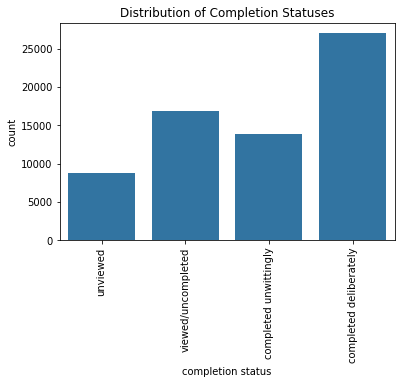

In [146]:
base_color = sb.color_palette()[0]
p = sb.countplot(data=df,x='completed',color = base_color, order=['unviewed','viewed/uncompleted','completed unwittingly','completed deliberately']);
plt.xticks(rotation=90);
plt.title('Distribution of Completion Statuses');
plt.xlabel('completion status');

So in general, most offers that are received are viewed and completed, suggesting that the offer was completed on purpose/with influence. About half as often, the offer is completed "accidentally" because it was not even viewed, which we're assuming means the person didn't even know about the offer. Slightly more often than that, an offer is viewed but not completed, which means the person wasn't interested or wasn't able to complete the offer. The least common scenario is that the offer is not viewed and not completed, which suggests that the person is not very active at Starbuck's.

Ultimately, we'd like to get an idea of who Starbuck's should send offers to - which type and through which delivery medium.
If we can find people who complete offers even though they're not influenced by them (didn't view), then Starbuck's could potentially not spend their efforts on them.

Let's see if there's any correlation between completing offers accidentally and the length of time a person has been a member

Text(0, 0.5, 'count')

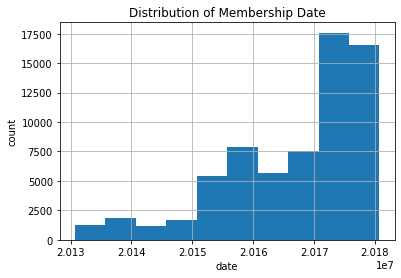

In [138]:
# First let's see a histogram for the became_member_on column to see how evenly distributed it is

df.hist(column='became_member_on');
plt.title('Distribution of Membership Date')
plt.xlabel('date')
plt.ylabel('count')

I think first it makes sense to the year that each person became a member

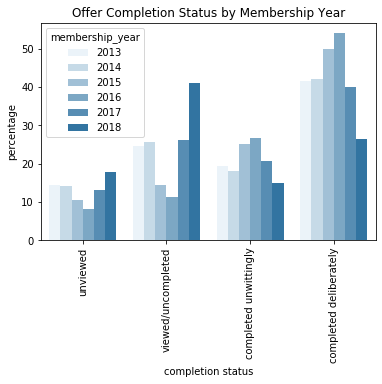

In [60]:
completed_counts = (df.groupby(['membership_year'])['completed']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('completed'))
completion_order = ['unviewed','viewed/uncompleted','completed unwittingly','completed deliberately']
p = sb.barplot(x="completed", y="percentage", hue="membership_year", data=completed_counts, order=completion_order,color=base_color)
plt.title('Offer Completion Status by Membership Year');
plt.xlabel('completion status');
plt.xticks(rotation=90);
# y label is percentage of members of each year in each category of offer completion
# sum of each hue color is 100%
# "40% of 2018 members' offers were viewed but incompleted"

In [61]:
df.membership_year.value_counts()

2017    25125
2018    16507
2016    13520
2015     7150
2014     2973
2013     1226
Name: membership_year, dtype: int64

Most of the most recent members (joined in 2018) view offers and don't complete them. Few complete them "accidentally". This is the only group where most of its members don't view and complete their offers.

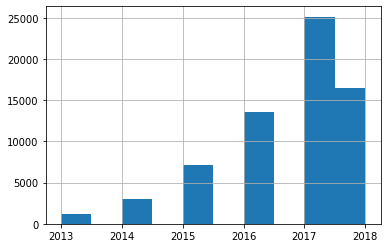

In [62]:
df.membership_year.hist();

Make plots for age and income as well.
First look at distribution of age and income.

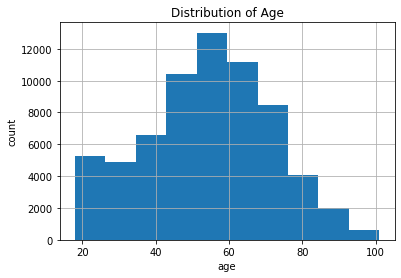

In [140]:
df.hist(column='age');
plt.title('Distribution of Age');
plt.xlabel('age');
plt.ylabel('count');

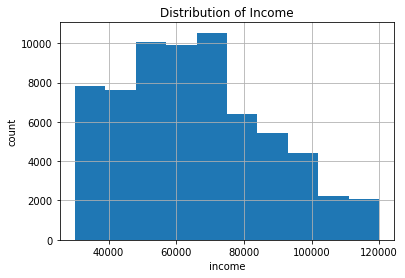

In [141]:
df.hist(column='income');
plt.title('Distribution of Income');
plt.xlabel('income');
plt.ylabel('count');

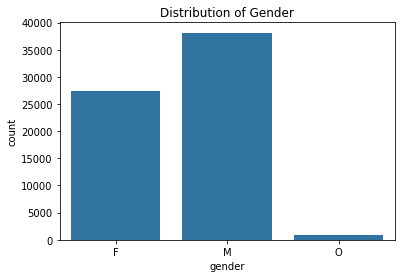

In [142]:
base_color = sb.color_palette()[0]
sb.countplot(data = df, x = 'gender', color=base_color);
plt.title('Distribution of Gender');

They're definitely not evenly distributed, so should use proportions, similarly to the plot with membership year.

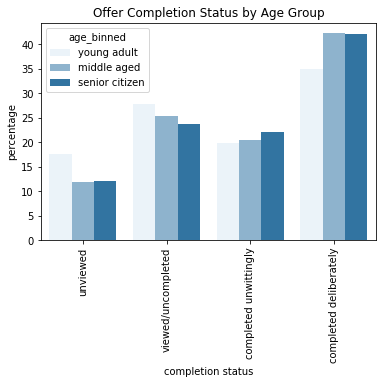

In [66]:
completed_counts_by_age = (df.groupby(['age_binned'])['completed']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('completed'))
completed_counts_by_age
base_color = sb.color_palette()[0]
p = sb.barplot(x="completed", y="percentage", hue="age_binned", data=completed_counts_by_age,color=base_color,order=completion_order)
plt.title('Offer Completion Status by Age Group')
plt.xlabel('completion status');
plt.xticks(rotation=90);

In [67]:
df.income.describe()

count     66501.000000
mean      65371.618472
std       21623.288473
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

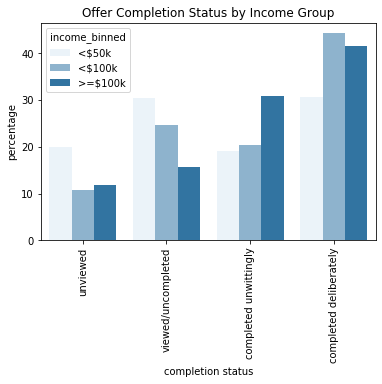

In [68]:
completed_counts_by_income = (df.groupby(['income_binned'])['completed']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('completed'))
completed_counts_by_income
base_color = sb.color_palette()[0]
p = sb.barplot(x="completed", y="percentage", hue="income_binned", data=completed_counts_by_income,color=base_color, order=completion_order)
plt.title('Offer Completion Status by Income Group')
plt.xlabel('completion status');
plt.xticks(rotation=90);

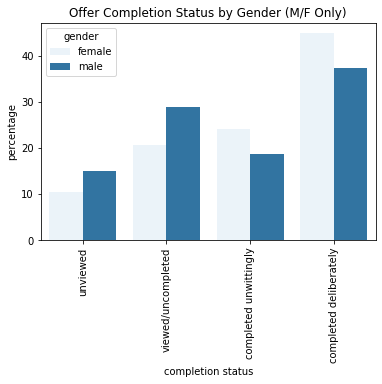

In [69]:
df_mf = df[(df.gender=='M') | (df.gender=='F')]
completed_counts_by_gender = (df_mf.groupby(['gender'])['completed']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('completed'))
completed_counts_by_gender
base_color = sb.color_palette()[0]
p = sb.barplot(x="completed", y="percentage", hue="gender", data=completed_counts_by_gender,color=base_color, order=completion_order)
h, l = p.get_legend_handles_labels()
p.legend(h, ['female','male'], title="gender")
plt.title('Offer Completion Status by Gender (M/F Only)')
plt.xlabel('completion status');
plt.xticks(rotation=90);

Most likely there's a correlation with age and income and that's why they have a similar effect.

Let's go back to the effect of membership age, and see how the newwest members respond to offers made through the various channels.

In [70]:
from collections import defaultdict

possible_vals_channels = ["web", "email", "mobile", "social"]

def total_count(df, col1, col2, look_for): # Copied from helper functions in Lesson 1
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of values
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the value is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

def clean_and_plot(df, possible_vals, col_to_clean='channels', title='Offer Channels', plot=True): # Copied from Lesson 1, adapted for NEWJobHunt variable
    '''
    *Make sure df is clean of NaNs in col_to_clean*
    INPUT 
        df - a dataframe holding the col_to_clean column
        col_to_clean - column in df for which we are finding counts
        possible_vals - possible values to look for in col_to_clean
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        study_df - a dataframe with the count of how many individuals
        (Optionally) displays a plot of pretty things related to the col_to_clean column.
        (Optionally) ax - axis handle to the plot
    '''
    study = df[col_to_clean].value_counts().reset_index()
    study.rename(columns={'index': 'value', col_to_clean: 'count'}, inplace=True)
    study_df = total_count(study, 'value', 'count', possible_vals)

    study_df.set_index('value', inplace=True)
    if plot:
#         ax=(study_df/study_df.sum()).plot(kind='bar', legend=None);
        ax=(study_df/df.shape[0]*100).plot(kind='bar', legend=None);
        plt.title(title);
#         plt.show()
#     out_df = study_df/study_df.sum()
    out_df = study_df/df.shape[0]
    # I had to change the above from study_df.sum() to df.shape[0] because we're interested in the proportion
    # of individuals choosing a certain answer, regardless of what additionally they chose
    
    try:
        out_df = out_df[0] # in case it comes out as a tuple
    except:
        out_df = out_df
    
    if plot:
        return out_df,ax
    else:
        return out_df

In [71]:
def make_chart(num_x_vals,df1,df2,title,leg=['White Men','Minorities']): # adapted from https://chrisalbon.com/python/data_visualization/matplotlib_grouped_bar_plot/
    # For now, make sure df1 and df2 indices are in the same order
    # Later, we can make df2 have same order as df1, which should be in some order that makes sense (decreasing for example)
    '''
    INPUT:
    num_x_vals - number of x-axis values you want to plot
    df1 - dataframe of first group
    df2 - dataframe of second group
    title - title for output plot
    (Optionally) leg - list of legend annotations

    OUTPUT:
    Displays a double bar plot of the 2 datasets
    '''
    
    
    df1_vals = []
    for i in range(df1.values.shape[0]):
        df1_vals.append(df1.values[i][0])
    df2_vals = []
    for i in range(df2.values.shape[0]):
        df2_vals.append(df2.values[i][0])
    
    # Setting the positions and width for the bars
    pos = list(range(num_x_vals)) 
    width = 0.25
#     width = 0.5

    # Plotting the bars
    fig, ax = plt.subplots(figsize=(10,5))

    # Create a bar with pre_score data,
    # in position pos,
    plt.bar([p + width for p in pos], 
            #using df['pre_score'] data,
            df1_vals,
            # of width
            width,
            # with alpha 0.5
            alpha=0.5, 
            # with color
            color='#EE3224', 
            # with label the first value in first_name
            label=df1.index[0])

    # Create a bar with mid_score data,
    # in position pos + some width buffer,
    plt.bar([p + width*2 for p in pos], 
            #using df['mid_score'] data,
            df2_vals,
            # of width
            width, 
            # with alpha 0.5
            alpha=0.5, 
            # with color
            color='#F78F1E', 
            # with label the second value in first_name
            label=df1.index[1])

    # Set the y axis label
    ax.set_ylabel('Proportion')

    # Set the chart's title
    ax.set_title(title)

    # Set the position of the x ticks
    ax.set_xticks([p + 1.5 * width for p in pos])

    # Set the labels for the x ticks
    ax.set_xticklabels(list(df1.index),rotation=90)
#     ax.xaxis.set_label_coords(-0.3, 0.5) #added as test

    # Setting the x-axis and y-axis limits
    plt.xlim(min(pos)-width, max(pos)+width*4)
#     plt.ylim([0, max(df1 + df2)])

    # Adding the legend and showing the plot
    plt.legend(leg, loc='upper right')
#     plt.grid()
    plt.show()

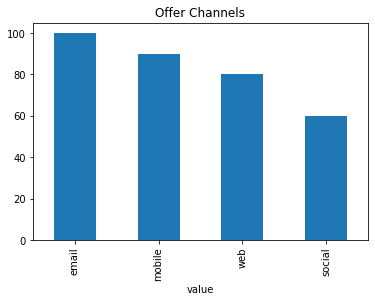

In [72]:
channel_counts,ax = clean_and_plot(df, possible_vals_channels, col_to_clean='channels', title='Offer Channels', plot=True)

In [73]:
# df_completed_2018members = df[(df.membership_year==2018) & (df.completed=='completed deliberately')]
# df_completed_oldermembers = df[(df.membership_year<2018) & (df.completed=='completed deliberately')]

df_unviewed_2018members = df[(df.membership_year==2018) & (df.completed=='unviewed')]
df_unviewed_oldermembers = df[(df.membership_year<2018) & (df.completed=='unviewed')]

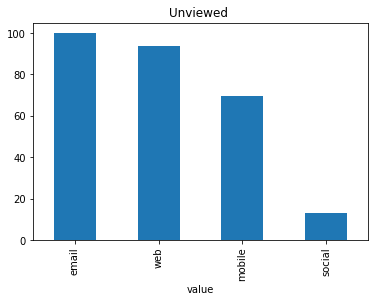

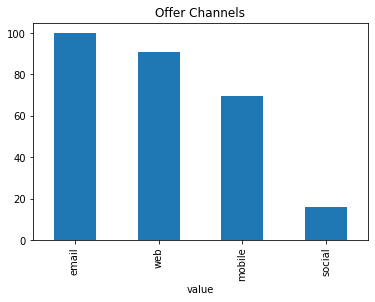

In [74]:
channel_counts_unviewed_2018members,ax = clean_and_plot(df_unviewed_2018members, possible_vals_channels, col_to_clean='channels', title='Offer Channels', plot=True)
plt.title('Unviewed ')
channel_counts_unviewed_oldermembers,ax = clean_and_plot(df_unviewed_oldermembers, possible_vals_channels, col_to_clean='channels', title='Offer Channels', plot=True)

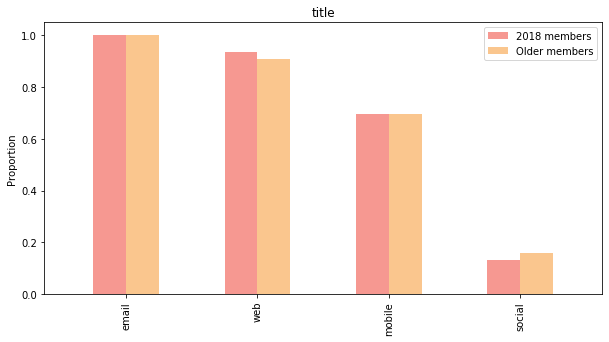

In [75]:
make_chart(channel_counts_unviewed_2018members.shape[0],channel_counts_unviewed_2018members,channel_counts_unviewed_oldermembers,'title',leg=['2018 members','Older members'])

So there's really no difference between new and older members in how they receive their viewed and completed offers. This suggests that the channel of delivery is not the reason why 2018 members ignore offers at a higher rate than other members.

Let's see about different age groups.

In [76]:
df_channels_split = df.copy()

def split_channels(vals):
    if channel in vals:
        return 1
    else:
        return 0
    
for channel in ['web','email','mobile','social']:
    df_channels_split[channel]=df_channels_split['channels'].apply(split_channels)

df_channels_split.head()

,person,gender,age,age_binned,became_member_on,membership_year,income,income_binned,offer_id_short,offer_type,time_received,duration,difficulty,reward,channels,completed,web,email,mobile,social
0,78afa995795e4d85b5d9ceeca43f5fef,F,75,senior citizen,20170509,2017,100000.0,>=$100k,9b98,bogo,0,168,5,5,"[web, email, mobile]",completed deliberately,1,1,1,0
1,e2127556f4f64592b11af22de27a7932,M,68,senior citizen,20180426,2018,70000.0,<$100k,2906,discount,0,168,10,2,"[web, email, mobile]",viewed/uncompleted,1,1,1,0
2,389bc3fa690240e798340f5a15918d5c,M,65,senior citizen,20180209,2018,53000.0,<$100k,f194,bogo,0,120,5,5,"[web, email, mobile, social]",completed deliberately,1,1,1,1
3,2eeac8d8feae4a8cad5a6af0499a211d,M,58,middle aged,20171111,2017,51000.0,<$100k,3f20,informational,0,96,0,0,"[web, email, mobile]",unviewed,1,1,1,0
4,aa4862eba776480b8bb9c68455b8c2e1,F,61,middle aged,20170911,2017,57000.0,<$100k,0b1e,discount,0,240,20,5,"[web, email]",viewed/uncompleted,1,1,0,0


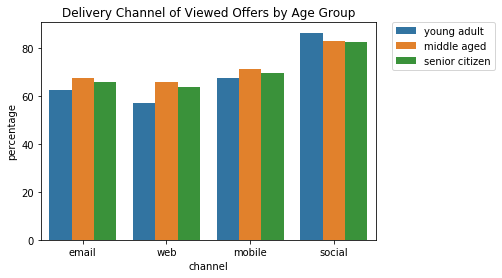

In [77]:
df_web = df_channels_split[df_channels_split.web==1]
df_email = df_channels_split[df_channels_split.email==1]
df_mobile = df_channels_split[df_channels_split.mobile==1]
df_social = df_channels_split[df_channels_split.social==1]

d_web = (df_web.groupby(['age_binned'])['completed'].value_counts(normalize=True).rename('percentages').mul(100).reset_index())
d_web
d_web = d_web[d_web.completed.isin(['completed deliberately','viewed/uncompleted'])]
d_web['channel']='web'
d_web

d_email = (df_email.groupby(['age_binned'])['completed'].value_counts(normalize=True).rename('percentages').mul(100).reset_index())
d_email
d_email = d_email[d_email.completed.isin(['completed deliberately','viewed/uncompleted'])]
d_email['channel']='email'
d_email

d_mobile = (df_mobile.groupby(['age_binned'])['completed'].value_counts(normalize=True).rename('percentages').mul(100).reset_index())
d_mobile
d_mobile = d_mobile[d_mobile.completed.isin(['completed deliberately','viewed/uncompleted'])]
d_mobile['channel']='mobile'
d_mobile

d_social = (df_social.groupby(['age_binned'])['completed'].value_counts(normalize=True).rename('percentages').mul(100).reset_index())
d_social
d_social = d_social[d_social.completed.isin(['completed deliberately','viewed/uncompleted'])]
d_social['channel']='social'
d_social

test = pd.concat([d_web,d_email,d_mobile,d_social]).reset_index()

test_plot = (test.groupby(['channel','age_binned'])['percentages'].sum().rename('percent').reset_index())

p = sb.barplot(x="channel", y="percent", hue="age_binned", data=test_plot,order=['email','web','mobile','social'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.ylabel('percentage');
plt.title('Delivery Channel of Viewed Offers by Age Group');

So, the social channel is important, especially for the young adult group.

In [78]:
df.head()

,person,gender,age,age_binned,became_member_on,membership_year,income,income_binned,offer_id_short,offer_type,time_received,duration,difficulty,reward,channels,completed
0,78afa995795e4d85b5d9ceeca43f5fef,F,75,senior citizen,20170509,2017,100000.0,>=$100k,9b98,bogo,0,168,5,5,"[web, email, mobile]",completed deliberately
1,e2127556f4f64592b11af22de27a7932,M,68,senior citizen,20180426,2018,70000.0,<$100k,2906,discount,0,168,10,2,"[web, email, mobile]",viewed/uncompleted
2,389bc3fa690240e798340f5a15918d5c,M,65,senior citizen,20180209,2018,53000.0,<$100k,f194,bogo,0,120,5,5,"[web, email, mobile, social]",completed deliberately
3,2eeac8d8feae4a8cad5a6af0499a211d,M,58,middle aged,20171111,2017,51000.0,<$100k,3f20,informational,0,96,0,0,"[web, email, mobile]",unviewed
4,aa4862eba776480b8bb9c68455b8c2e1,F,61,middle aged,20170911,2017,57000.0,<$100k,0b1e,discount,0,240,20,5,"[web, email]",viewed/uncompleted


In [79]:
df[df.offer_type=='bogo'].offer_id_short.value_counts()

9b98    6685
ae26    6683
4d5c    6593
f194    6576
Name: offer_id_short, dtype: int64

In [80]:
portfolio_clean

,reward,channels,difficulty,duration,offer_type,id,id_short
0,10,"[email, mobile, social]",10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,ae26
1,10,"[web, email, mobile, social]",10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,4d5c
2,0,"[web, email, mobile]",0,96,informational,3f207df678b143eea3cee63160fa8bed,3f20
3,5,"[web, email, mobile]",5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98
4,5,"[web, email]",20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e
5,3,"[web, email, mobile, social]",7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,2298
6,2,"[web, email, mobile, social]",10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,fafd
7,0,"[email, mobile, social]",0,72,informational,5a8bc65990b245e5a138643cd4eb9837,5a8b
8,5,"[web, email, mobile, social]",5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,f194
9,2,"[web, email, mobile]",10,168,discount,2906b810c7d4411798c6938adc9daaa5,2906


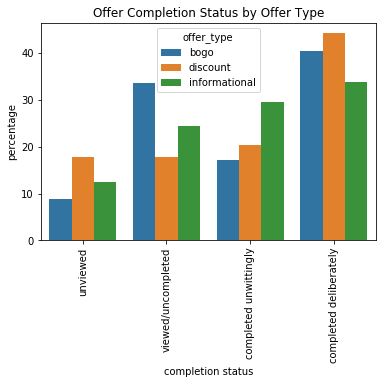

In [81]:
completed_counts_by_offer_type = (df.groupby(['offer_type'])['completed']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('completed'))
completed_counts_by_offer_type
p = sb.barplot(x="completed", y="percentage", hue="offer_type", data=completed_counts_by_offer_type,order=completion_order)
p.set_xlabel('completion status');
plt.xticks(rotation=90);
plt.title('Offer Completion Status by Offer Type');

There appears to be a disproportionately higher percentage of bogo offers that are viewed and unfulfilled. This suggests that bogo offers may be harder to fulfil. Or, there may be a subset of bogo offers (higher "difficulty" ones) that members don't want to or are unable to fulfil.

Informational offers are fulfilled almost at an equal rate "accidentally" vs after viewing, which suggests they may not be so influencial in general.

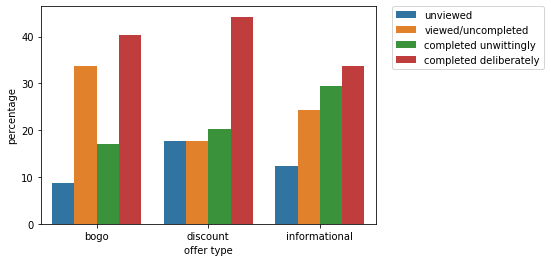

In [83]:
# Make above graph slightly differently

offer_type_by_completed_counts = (df.groupby(['offer_type'])['completed']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('offer_type'))
offer_type_by_completed_counts
p = sb.barplot(x="offer_type", y="percentage", hue="completed", data=offer_type_by_completed_counts,hue_order=['unviewed','viewed/uncompleted','completed unwittingly','completed deliberately'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
p.set_xlabel('offer type');
plt.show(p)

This suggests that people in general are likely to willingly complete discount offers. BOGO offers are likely to be completed, but also almost as likely to be viewed and not completed. Informational offers seem less useful; the rate of accidentally fulfilling the informational offer is almost the same as making a transaction after viewing it.

Now check more specifically about certain offers.

In [84]:
portfolio_clean

,reward,channels,difficulty,duration,offer_type,id,id_short
0,10,"[email, mobile, social]",10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,ae26
1,10,"[web, email, mobile, social]",10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,4d5c
2,0,"[web, email, mobile]",0,96,informational,3f207df678b143eea3cee63160fa8bed,3f20
3,5,"[web, email, mobile]",5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98
4,5,"[web, email]",20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e
5,3,"[web, email, mobile, social]",7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,2298
6,2,"[web, email, mobile, social]",10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,fafd
7,0,"[email, mobile, social]",0,72,informational,5a8bc65990b245e5a138643cd4eb9837,5a8b
8,5,"[web, email, mobile, social]",5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,f194
9,2,"[web, email, mobile]",10,168,discount,2906b810c7d4411798c6938adc9daaa5,2906


In [85]:
# for plots, specify an order
# decided to group types together; then order by rising difficulty and then channels from most to least

offer_id_order = ['f194','9b98','4d5c','ae26','2298','fafd','2906','0b1e','5a8b','3f20']

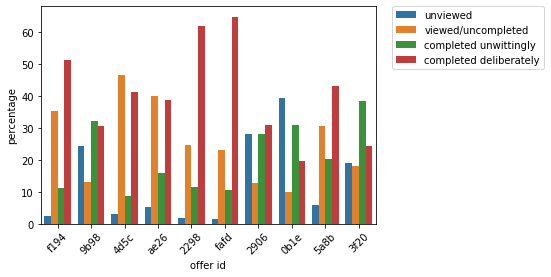

In [86]:
offer_by_completed_counts = (df.groupby(['offer_id_short'])['completed']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('offer_id_short'))
offer_by_completed_counts
p = sb.barplot(x="offer_id_short", y="percentage", hue="completed", order=offer_id_order,data=offer_by_completed_counts,hue_order=['unviewed','viewed/uncompleted','completed unwittingly','completed deliberately'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
p.set_xlabel('offer id');
plt.xticks(rotation=45)
plt.show(p)

Let's look at it with x and hue variables exchanged. Percentage is still percent of specific offer.

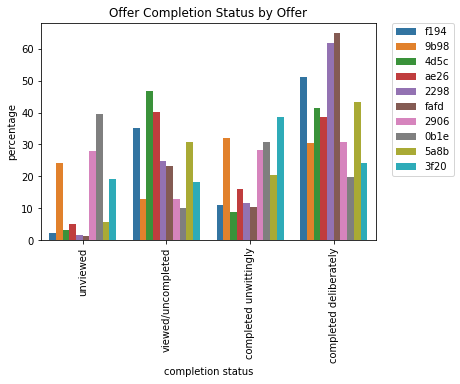

In [87]:
completed_counts_by_offer = (df.groupby(['offer_id_short'])['completed']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('completed'))
completed_counts_by_offer
p = sb.barplot(x="completed", y="percentage", hue="offer_id_short", hue_order = offer_id_order, order=completion_order,data=completed_counts_by_offer)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
p.set_xlabel('offer status');
plt.xticks(rotation=90);
plt.title('Offer Completion Status by Offer')
plt.xlabel('completion status');

In [88]:
portfolio_clean

,reward,channels,difficulty,duration,offer_type,id,id_short
0,10,"[email, mobile, social]",10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,ae26
1,10,"[web, email, mobile, social]",10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,4d5c
2,0,"[web, email, mobile]",0,96,informational,3f207df678b143eea3cee63160fa8bed,3f20
3,5,"[web, email, mobile]",5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98
4,5,"[web, email]",20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e
5,3,"[web, email, mobile, social]",7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,2298
6,2,"[web, email, mobile, social]",10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,fafd
7,0,"[email, mobile, social]",0,72,informational,5a8bc65990b245e5a138643cd4eb9837,5a8b
8,5,"[web, email, mobile, social]",5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,f194
9,2,"[web, email, mobile]",10,168,discount,2906b810c7d4411798c6938adc9daaa5,2906


In [90]:
# high rate of unviewed
# this is to put in the blog
order = ['0b1e', '2906', '9b98','3f20']
portfolio_clean[portfolio_clean.id_short.isin(order)].loc[[4,9,3,2]]

,reward,channels,difficulty,duration,offer_type,id,id_short
4,5,"[web, email]",20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e
9,2,"[web, email, mobile]",10,168,discount,2906b810c7d4411798c6938adc9daaa5,2906
3,5,"[web, email, mobile]",5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98
2,0,"[web, email, mobile]",0,96,informational,3f207df678b143eea3cee63160fa8bed,3f20


In general, across the population, the offer sent only through web and email is not even being viewed far more often than other offers. Next highest unviewed offers are those that are not delivered through social channels.

See how this spans across different age groups.

Now make the above plot separating different demographics

In [91]:
df.head()

,person,gender,age,age_binned,became_member_on,membership_year,income,income_binned,offer_id_short,offer_type,time_received,duration,difficulty,reward,channels,completed
0,78afa995795e4d85b5d9ceeca43f5fef,F,75,senior citizen,20170509,2017,100000.0,>=$100k,9b98,bogo,0,168,5,5,"[web, email, mobile]",completed deliberately
1,e2127556f4f64592b11af22de27a7932,M,68,senior citizen,20180426,2018,70000.0,<$100k,2906,discount,0,168,10,2,"[web, email, mobile]",viewed/uncompleted
2,389bc3fa690240e798340f5a15918d5c,M,65,senior citizen,20180209,2018,53000.0,<$100k,f194,bogo,0,120,5,5,"[web, email, mobile, social]",completed deliberately
3,2eeac8d8feae4a8cad5a6af0499a211d,M,58,middle aged,20171111,2017,51000.0,<$100k,3f20,informational,0,96,0,0,"[web, email, mobile]",unviewed
4,aa4862eba776480b8bb9c68455b8c2e1,F,61,middle aged,20170911,2017,57000.0,<$100k,0b1e,discount,0,240,20,5,"[web, email]",viewed/uncompleted


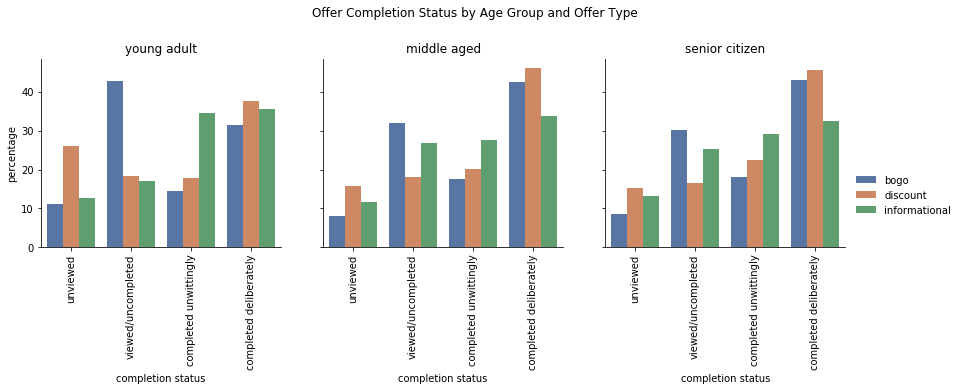

In [92]:
counts2 = (df.groupby(['age_binned','offer_type'])['completed']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values(['age_binned','offer_type']))
counts2

g = sb.FacetGrid(counts2, col='age_binned', col_wrap=3, height=4, col_order = ['young adult','middle aged','senior citizen']);
g.map(sb.barplot,'completed','percentage','offer_type', hue_order = ['bogo','discount','informational'], order=['unviewed','viewed/uncompleted','completed unwittingly','completed deliberately'], palette="deep").add_legend();

axes = g.axes.flatten();
axes[0].set_title("young adult");
axes[1].set_title("middle aged");
axes[2].set_title("senior citizen");

plt.subplots_adjust(top=0.9)
g.fig.suptitle('TITLE');
axes[0].set_xlabel("completion status");
axes[1].set_xlabel("completion status");
axes[2].set_xlabel("completion status");

axes[0].set_xticklabels(labels=completion_order,rotation=90)
axes[1].set_xticklabels(labels=completion_order,rotation=90)
axes[2].set_xticklabels(labels=completion_order,rotation=90)


plt.subplots_adjust(top=0.8) #top=0.9
g.fig.suptitle('Offer Completion Status by Age Group and Offer Type');

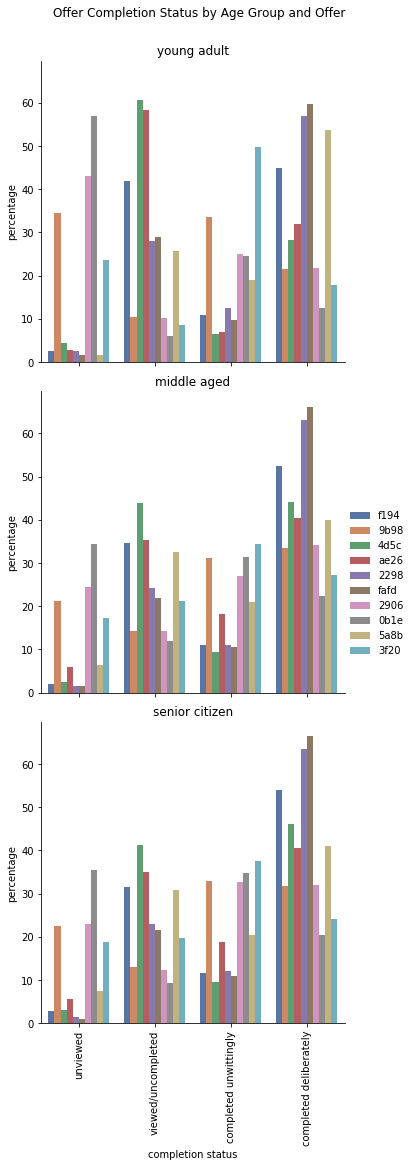

In [93]:
counts2 = (df.groupby(['age_binned','offer_id_short'])['completed']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values(['completed','offer_id_short']))
counts2

g = sb.FacetGrid(counts2, col='age_binned', col_wrap=1, height=5, col_order = ['young adult','middle aged','senior citizen']);
g.map(sb.barplot,'completed','percentage','offer_id_short', order=['unviewed','viewed/uncompleted','completed unwittingly','completed deliberately'], hue_order = offer_id_order, palette="deep").add_legend();

axes = g.axes.flatten();
axes[0].set_title("young adult");
axes[1].set_title("middle aged");
axes[2].set_title("senior citizen");

plt.subplots_adjust(top=.93)
g.fig.suptitle('Offer Completion Status by Age Group and Offer');
axes[2].set_xlabel("completion status");
axes[2].set_xticklabels(axes[2].get_xticklabels(), 
                          rotation=90);

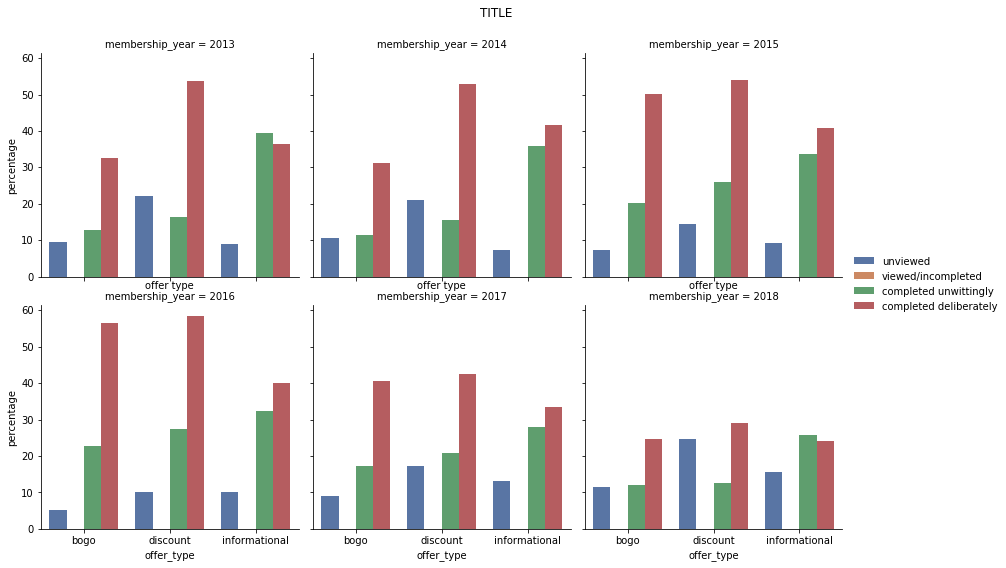

In [94]:
counts2 = (df.groupby(['membership_year','offer_type'])['completed']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values(['membership_year','offer_type']))
counts2

g = sb.FacetGrid(counts2, col='membership_year', col_wrap=3, height=4);
g.map(sb.barplot,'offer_type','percentage','completed', order = ['bogo','discount','informational'], hue_order=['unviewed','viewed/incompleted','completed unwittingly','completed deliberately'], palette="deep").add_legend();

axes = g.axes.flatten();

plt.subplots_adjust(top=0.9)
g.fig.suptitle('TITLE');
axes[0].set_xlabel("offer type");
axes[1].set_xlabel("offer type");
axes[2].set_xlabel("offer type");

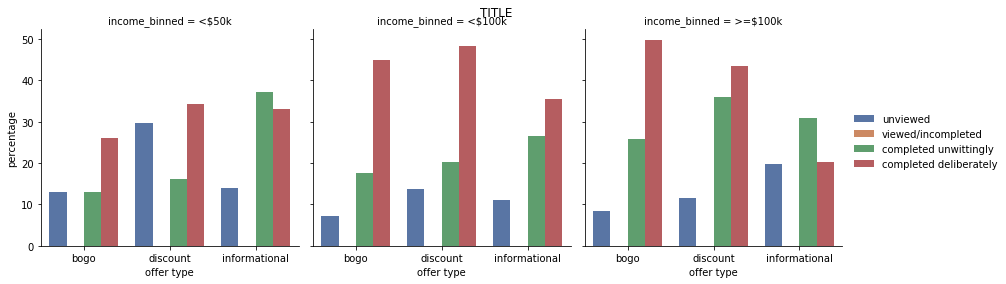

In [96]:
counts2 = (df.groupby(['income_binned','offer_type'])['completed']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values(['income_binned','offer_type']))
counts2

g = sb.FacetGrid(counts2, col='income_binned', col_wrap=3, height=4, col_order = ['<$50k','<$100k','>=$100k']);
g.map(sb.barplot,'offer_type','percentage','completed', order = ['bogo','discount','informational'], hue_order=['unviewed','viewed/incompleted','completed unwittingly','completed deliberately'], palette="deep").add_legend();

axes = g.axes.flatten();

plt.subplots_adjust(top=0.9)
g.fig.suptitle('TITLE');
axes[0].set_xlabel("offer type");
axes[1].set_xlabel("offer type");
axes[2].set_xlabel("offer type");

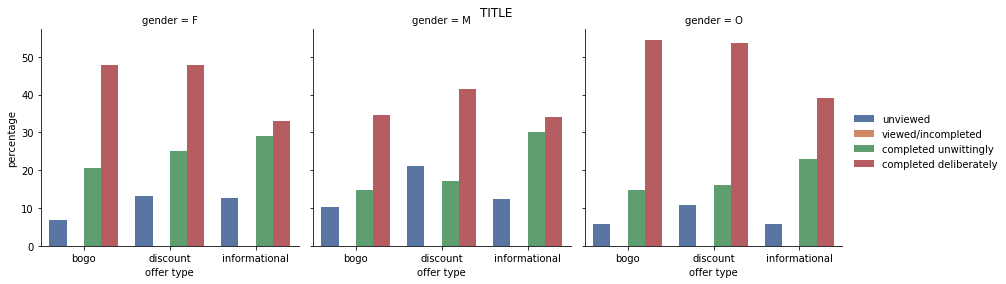

In [97]:
counts2 = (df.groupby(['gender','offer_type'])['completed']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values(['gender','offer_type']))
counts2

g = sb.FacetGrid(counts2, col='gender', col_wrap=3, height=4);
g.map(sb.barplot,'offer_type','percentage','completed', order = ['bogo','discount','informational'], hue_order=['unviewed','viewed/incompleted','completed unwittingly','completed deliberately'], palette="deep").add_legend();

axes = g.axes.flatten();

plt.subplots_adjust(top=0.9)
g.fig.suptitle('TITLE');
axes[0].set_xlabel("offer type");
axes[1].set_xlabel("offer type");
axes[2].set_xlabel("offer type");

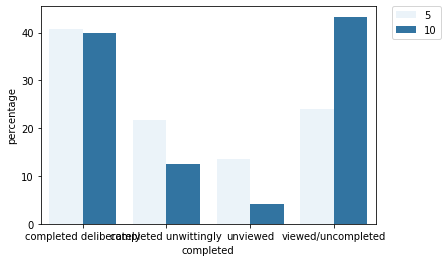

In [100]:
completed_counts_bogo = (df_bogo.groupby(['difficulty'])['completed']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('completed'))
completed_counts_bogo
base_color = sb.color_palette()[0]
p = sb.barplot(x="completed", y="percentage", hue="difficulty", data=completed_counts_bogo, color=base_color)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);


Actually, both types of BOGO offers get completed at the same rate.

At this point, I realized I'd like to look at all of the transactions and determine if they were made with or without the influence of a promotional offer, and if so, which one. This will give me a better understanding of how users spend with and without receiving offers. So, I modified my earlier determine_influence function.

In [101]:
transcript_transaction[~transcript_transaction.influenced.isnull()]
transcript_transaction.head()
# transcript_transaction.shape[0]

,person,event,time,value,influenced
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83,ae264e3637204a6fb9bb56bc8210ddfd
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56,2906b810c7d4411798c6938adc9daaa5
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97,NaN


Look at distributions first between transactions influenced by offers and those without, then based on offer type, then based on specific offer

In [102]:
transcript_transaction.rename(columns = {'influenced':'offer_influenced'},inplace=True)
transcript_transaction['influenced']=~transcript_transaction.offer_influenced.isnull()

C:\Users\dagus\Anaconda3\envs\udacity\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [103]:
transcript_transaction.head()

,person,event,time,value,offer_influenced,influenced
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83,ae264e3637204a6fb9bb56bc8210ddfd,True
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56,2906b810c7d4411798c6938adc9daaa5,True
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23,NaN,False
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51,NaN,False
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97,NaN,False


In [104]:
transcript_transaction.drop('event',axis=1,inplace=True)

In [105]:
transcript_transaction.sample(5)

,person,time,value,offer_influenced,influenced
52963,a6105ca2ed8f4ce4b1b73f98b9b82c3a,162,2.13,NaN,False
94349,a8d40bf3f96843ae8a16aafd85deaabf,246,4.69,NaN,False
198123,2a250c4bd80c4f60b6c3c7cdf322cca1,486,9.89,NaN,False
131611,de647c886acc4a89bbe7d7e2115284d8,348,24.28,2298d6c36e964ae4a3e7e9706d1fb8c2,True
215044,670e88a883124c71b74c854e964270c1,504,16.33,NaN,False


We'll need to add some additional column data to this dataframe.
Start by joining it with the portfolio table.

In [106]:
df2 = pd.merge(transcript_transaction,portfolio_clean,how='left',left_on='offer_influenced',right_on='id')
df2.head(10)

,person,time,value,offer_influenced,influenced,reward,channels,difficulty,duration,offer_type,id,id_short
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,ae264e3637204a6fb9bb56bc8210ddfd,True,10.0,"[email, mobile, social]",10.0,168.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,ae26
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,2906b810c7d4411798c6938adc9daaa5,True,2.0,"[web, email, mobile]",10.0,168.0,discount,2906b810c7d4411798c6938adc9daaa5,2906
2,54890f68699049c2a04d415abc25e717,0,13.23,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,629fc02d56414d91bca360decdfa9288,0,33.9,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,5.0,"[web, email, mobile]",5.0,168.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98
6,a97e6f33219c432db82acfa0d19c602d,0,18.59,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,676506bad68e4161b9bbaffeb039626b,0,18.01,ae264e3637204a6fb9bb56bc8210ddfd,True,10.0,"[email, mobile, social]",10.0,168.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,ae26
8,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,19.11,4d5c57ea9a6940dd891ad53e9dbe8da0,True,10.0,"[web, email, mobile, social]",10.0,120.0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,4d5c
9,4cbe33c601a5407f8202086565c55111,0,36.19,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
df2.drop(['duration','id','offer_influenced'],axis=1,inplace=True)
df2.head()

,person,time,value,influenced,reward,channels,difficulty,offer_type,id_short
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,True,10.0,"[email, mobile, social]",10.0,bogo,ae26
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,True,2.0,"[web, email, mobile]",10.0,discount,2906
2,54890f68699049c2a04d415abc25e717,0,13.23,False,NaN,NaN,NaN,NaN,NaN
3,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,False,NaN,NaN,NaN,NaN,NaN
4,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,False,NaN,NaN,NaN,NaN,NaN


In [108]:
df2 = pd.merge(df2,profile_clean,how='left',left_on='person',right_on='id')
df2.head()

,person,time,value,influenced,reward,channels,difficulty,offer_type,id_short,gender,age,id,became_member_on,income,membership_year,age_binned,income_binned
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,True,10.0,"[email, mobile, social]",10.0,bogo,ae26,F,20,02c083884c7d45b39cc68e1314fec56c,20160711,30000.0,2016,young adult,<$50k
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,True,2.0,"[web, email, mobile]",10.0,discount,2906,M,42,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,20160117,96000.0,2016,middle aged,<$100k
2,54890f68699049c2a04d415abc25e717,0,13.23,False,NaN,NaN,NaN,NaN,NaN,M,36,54890f68699049c2a04d415abc25e717,20171228,56000.0,2017,young adult,<$100k
3,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,False,NaN,NaN,NaN,NaN,NaN,F,55,b2f1cd155b864803ad8334cdf13c4bd2,20171016,94000.0,2017,middle aged,<$100k
4,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,False,NaN,NaN,NaN,NaN,NaN,F,39,fe97aa22dd3e48c8b143116a8403dd52,20171217,67000.0,2017,young adult,<$100k


In [109]:
df2.drop('id',axis=1,inplace=True)

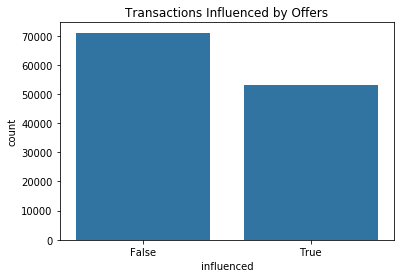

In [110]:
sb.countplot(data=df2,x='influenced',color = base_color); # number of transactions
plt.title('Transactions Influenced by Offers');

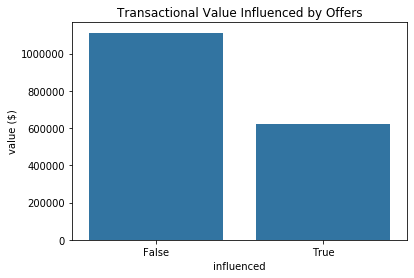

In [111]:
df2_by_influence = (df2.groupby(['influenced'])['value']
                     .sum()
                     .reset_index())

p = sb.barplot(x="influenced", y="value", data=df2_by_influence, color=base_color) # total $
plt.title('Transactional Value Influenced by Offers');
plt.ylabel('value ($)');

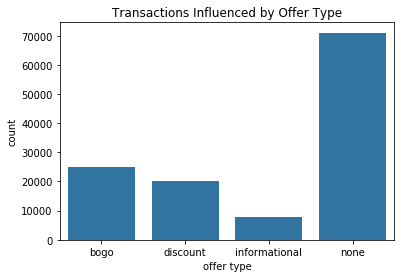

In [112]:
offer_type_order = ['bogo','discount','informational','none']
df2_null = df2.copy()
df2_null['offer_type'] = df2_null.offer_type.fillna(value='none')
df2_null
df2_null['id_short'] = df2_null.id_short.fillna(value='none')
df2_null

sb.countplot(data=df2_null,x='offer_type',order=offer_type_order,color=base_color); # might change order
plt.xlabel('offer type');
plt.title('Transactions Influenced by Offer Type');

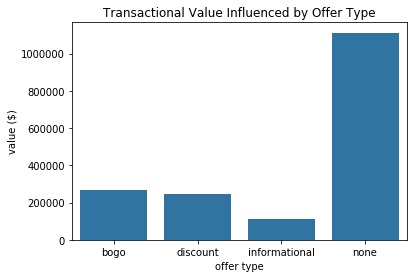

In [113]:
df2_by_offer_type = (df2_null.groupby(['offer_type'])['value']
                     .sum()
                     .reset_index())

p = sb.barplot(x="offer_type", y="value", data=df2_by_offer_type, color=base_color) # total $
plt.title('Transactional Value Influenced by Offer Type');
plt.ylabel('value ($)');
plt.xlabel('offer type');

But the above graphs are affected by how many of each type of offer was presented.

In [114]:
df.head()

,person,gender,age,age_binned,became_member_on,membership_year,income,income_binned,offer_id_short,offer_type,time_received,duration,difficulty,reward,channels,completed
0,78afa995795e4d85b5d9ceeca43f5fef,F,75,senior citizen,20170509,2017,100000.0,>=$100k,9b98,bogo,0,168,5,5,"[web, email, mobile]",completed deliberately
1,e2127556f4f64592b11af22de27a7932,M,68,senior citizen,20180426,2018,70000.0,<$100k,2906,discount,0,168,10,2,"[web, email, mobile]",viewed/uncompleted
2,389bc3fa690240e798340f5a15918d5c,M,65,senior citizen,20180209,2018,53000.0,<$100k,f194,bogo,0,120,5,5,"[web, email, mobile, social]",completed deliberately
3,2eeac8d8feae4a8cad5a6af0499a211d,M,58,middle aged,20171111,2017,51000.0,<$100k,3f20,informational,0,96,0,0,"[web, email, mobile]",unviewed
4,aa4862eba776480b8bb9c68455b8c2e1,F,61,middle aged,20170911,2017,57000.0,<$100k,0b1e,discount,0,240,20,5,"[web, email]",viewed/uncompleted


Text(0.5, 1.0, 'Number of Offers Received')

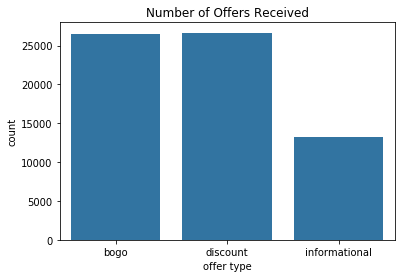

In [115]:
sb.countplot(x='offer_type', data=df, order=None,color=base_color)
plt.xlabel('offer type');
plt.title('Number of Offers Received')

In [116]:
df2.head()

,person,time,value,influenced,reward,channels,difficulty,offer_type,id_short,gender,age,became_member_on,income,membership_year,age_binned,income_binned
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,True,10.0,"[email, mobile, social]",10.0,bogo,ae26,F,20,20160711,30000.0,2016,young adult,<$50k
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,True,2.0,"[web, email, mobile]",10.0,discount,2906,M,42,20160117,96000.0,2016,middle aged,<$100k
2,54890f68699049c2a04d415abc25e717,0,13.23,False,NaN,NaN,NaN,NaN,NaN,M,36,20171228,56000.0,2017,young adult,<$100k
3,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,False,NaN,NaN,NaN,NaN,NaN,F,55,20171016,94000.0,2017,middle aged,<$100k
4,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,False,NaN,NaN,NaN,NaN,NaN,F,39,20171217,67000.0,2017,young adult,<$100k


In [117]:
df2_null.offer_type.value_counts()

none             71013
bogo             24999
discount         20001
informational     7944
Name: offer_type, dtype: int64

Do transactions influenced by offers for different groups, both by count and value

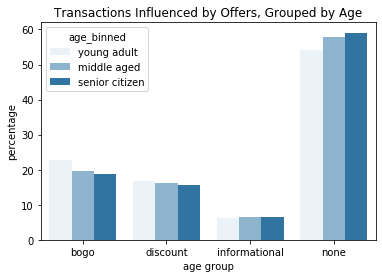

In [118]:
df2_age_binned = (df2_null.groupby(['age_binned'])['offer_type']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('age_binned'))
df2_age_binned
p = sb.barplot(x="offer_type", y="percentage", hue="age_binned", data=df2_age_binned,order=offer_type_order,color=base_color)
p.set_xlabel('age group');
plt.title('Transactions Influenced by Offers, Grouped by Age');
plt.show(p)

C:\Users\dagus\Anaconda3\envs\udacity\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


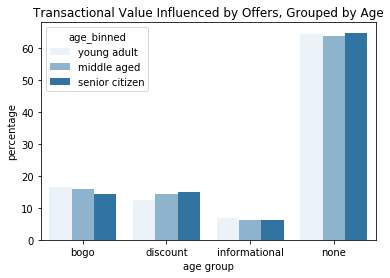

In [119]:
df2_age_binned = (df2_null.groupby(['age_binned','offer_type'])['value']
                     .sum()
                     .rename('money_spent')
                     .reset_index()
                     .sort_values('age_binned'))

sum_spent = (df2_age_binned.groupby(['age_binned']))['money_spent'].sum()

df2_age_binned['total_spent']=np.nan
df2_age_binned.total_spent.iloc[0:4] = sum_spent['young adult']
df2_age_binned.total_spent.iloc[4:8] = sum_spent['middle aged']
df2_age_binned.total_spent.iloc[8:] = sum_spent['senior citizen']

df2_age_binned['percentage']=df2_age_binned.money_spent/df2_age_binned.total_spent*100
df2_age_binned

p = sb.barplot(x="offer_type", y="percentage", hue="age_binned", data=df2_age_binned,order=offer_type_order,color=base_color)
p.set_xlabel('age group');
plt.title('Transactional Value Influenced by Offers, Grouped by Age');
plt.show(p)

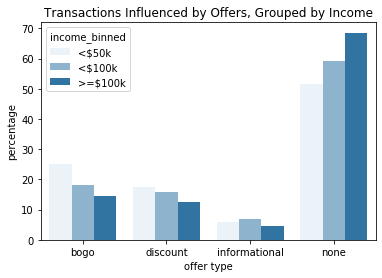

In [120]:
df2_income_binned = (df2_null.groupby(['income_binned'])['offer_type']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('income_binned'))
df2_income_binned
p = sb.barplot(x="offer_type", y="percentage", hue="income_binned", data=df2_income_binned,order=offer_type_order,color=base_color)
p.set_xlabel('offer type');
plt.title('Transactions Influenced by Offers, Grouped by Income');
plt.show(p)

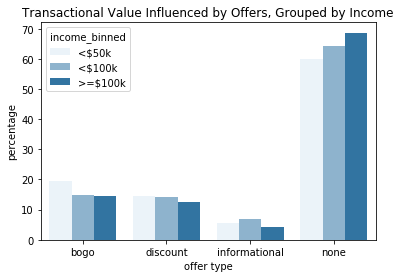

In [121]:
df2_income_binned = (df2_null.groupby(['income_binned','offer_type'])['value']
                     .sum()
                     .rename('money_spent')
                     .reset_index()
                     .sort_values('income_binned'))

sum_spent = (df2_income_binned.groupby(['income_binned']))['money_spent'].sum()

df2_income_binned['total_spent']=np.nan
df2_income_binned.total_spent.iloc[0:4] = sum_spent['<$50k']
df2_income_binned.total_spent.iloc[4:8] = sum_spent['<$100k']
df2_income_binned.total_spent.iloc[8:] = sum_spent['>=$100k']

df2_income_binned['percentage']=df2_income_binned.money_spent/df2_income_binned.total_spent*100
df2_income_binned

p = sb.barplot(x="offer_type", y="percentage", hue="income_binned", data=df2_income_binned,order=offer_type_order,color=base_color)
p.set_xlabel('offer type');
plt.title('Transactional Value Influenced by Offers, Grouped by Income');
plt.show(p)

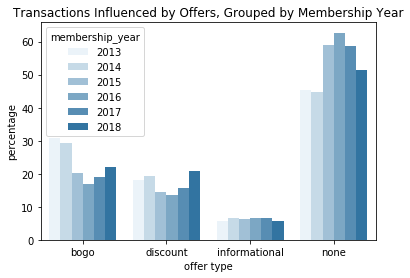

In [122]:
df2_membership_year = (df2_null.groupby(['membership_year'])['offer_type']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('membership_year'))
df2_membership_year
p = sb.barplot(x="offer_type", y="percentage", hue="membership_year", data=df2_membership_year,order=offer_type_order,color=base_color)
p.set_xlabel('offer type');
plt.title('Transactions Influenced by Offers, Grouped by Membership Year');
plt.show(p)

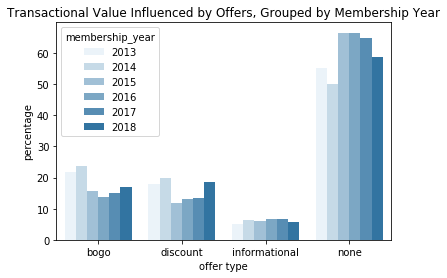

In [123]:
df2_membership_year = (df2_null.groupby(['membership_year','offer_type'])['value']
                     .sum()
                     .rename('money_spent')
                     .reset_index()
                     .sort_values('membership_year'))

sum_spent = (df2_membership_year.groupby(['membership_year']))['money_spent'].sum()

df2_membership_year['total_spent']=np.nan
df2_membership_year.total_spent.iloc[0:4] = sum_spent[2013]
df2_membership_year.total_spent.iloc[4:8] = sum_spent[2014]
df2_membership_year.total_spent.iloc[8:12] = sum_spent[2015]
df2_membership_year.total_spent.iloc[12:16] = sum_spent[2016]
df2_membership_year.total_spent.iloc[16:20] = sum_spent[2017]
df2_membership_year.total_spent.iloc[20:] = sum_spent[2018]

df2_membership_year['percentage']=df2_membership_year.money_spent/df2_membership_year.total_spent*100
df2_membership_year

p = sb.barplot(x="offer_type", y="percentage", hue="membership_year", data=df2_membership_year,order=offer_type_order,color=base_color)
p.set_xlabel('offer type');
plt.title('Transactional Value Influenced by Offers, Grouped by Membership Year');
plt.show(p)

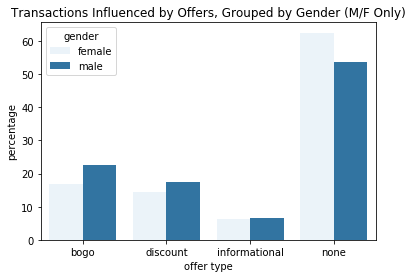

In [124]:
df2_null_mf = df2_null[(df2_null.gender=='M') | (df2_null.gender=='F')]
df2_gender = (df2_null_mf.groupby(['gender'])['offer_type']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('gender'))
df2_gender
p = sb.barplot(x="offer_type", y="percentage", hue="gender", data=df2_gender,order=offer_type_order,color=base_color)
p.set_xlabel('offer type');
plt.title('Transactions Influenced by Offers, Grouped by Gender (M/F Only)');
h, l = p.get_legend_handles_labels()
p.legend(h, ['female','male'], title="gender")
plt.show(p)

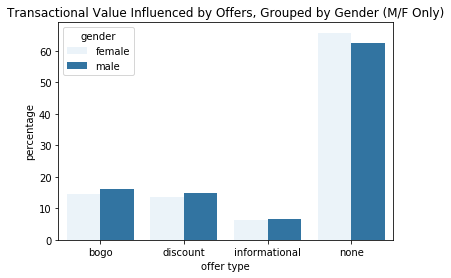

In [125]:
df2_gender = (df2_null_mf.groupby(['gender','offer_type'])['value']
                     .sum()
                     .rename('money_spent')
                     .reset_index()
                     .sort_values('gender'))

sum_spent = (df2_gender.groupby(['gender']))['money_spent'].sum()

df2_gender['total_spent']=np.nan
df2_gender.total_spent.iloc[0:4] = sum_spent['F']
df2_gender.total_spent.iloc[4:] = sum_spent['M']

df2_gender['percentage']=df2_gender.money_spent/df2_gender.total_spent*100
df2_gender

p = sb.barplot(x="offer_type", y="percentage", hue="gender", data=df2_gender,order=offer_type_order,color=base_color)
p.set_xlabel('offer type');
plt.title('Transactional Value Influenced by Offers, Grouped by Gender (M/F Only)');
h, l = p.get_legend_handles_labels()
p.legend(h, ['female','male'], title="gender")
plt.show(p)

Make sure each demographic group is getting about the same number of each offer (by offers/person in each group)

In [126]:
# go back to df, which has a row for every offer received
df.head()

,person,gender,age,age_binned,became_member_on,membership_year,income,income_binned,offer_id_short,offer_type,time_received,duration,difficulty,reward,channels,completed
0,78afa995795e4d85b5d9ceeca43f5fef,F,75,senior citizen,20170509,2017,100000.0,>=$100k,9b98,bogo,0,168,5,5,"[web, email, mobile]",completed deliberately
1,e2127556f4f64592b11af22de27a7932,M,68,senior citizen,20180426,2018,70000.0,<$100k,2906,discount,0,168,10,2,"[web, email, mobile]",viewed/uncompleted
2,389bc3fa690240e798340f5a15918d5c,M,65,senior citizen,20180209,2018,53000.0,<$100k,f194,bogo,0,120,5,5,"[web, email, mobile, social]",completed deliberately
3,2eeac8d8feae4a8cad5a6af0499a211d,M,58,middle aged,20171111,2017,51000.0,<$100k,3f20,informational,0,96,0,0,"[web, email, mobile]",unviewed
4,aa4862eba776480b8bb9c68455b8c2e1,F,61,middle aged,20170911,2017,57000.0,<$100k,0b1e,discount,0,240,20,5,"[web, email]",viewed/uncompleted


In [127]:
def make_offer_type_count(df,group):
    offer_counts_per_group = (df.groupby([group])['offer_type'].value_counts().rename('num').reset_index().sort_values([group,'offer_type']))
    group_head_count = df.drop_duplicates(subset='person').groupby(group).person.count().rename('total').reset_index().sort_values([group])
    offer_counts_per_group = pd.merge(offer_counts_per_group,group_head_count,how='left',on=group)
    offer_counts_per_group['count_per_person'] = offer_counts_per_group.num/offer_counts_per_group.total
    offer_counts_per_group.rename(columns={group:"group"},inplace=True)
    return offer_counts_per_group

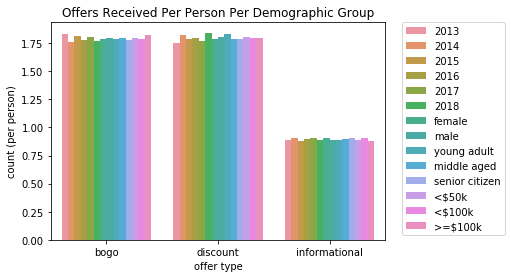

In [128]:
count1=make_offer_type_count(df,'membership_year')
count2=make_offer_type_count(df_mf,'gender')
count3=make_offer_type_count(df,'age_binned')
count4=make_offer_type_count(df,'income_binned')

# make into one dataframe by stacking
frames = [count1, count2, count3, count4]
to_plot = pd.concat(frames).reset_index()
to_plot.group.replace(to_replace=['F','M'],value=['female','male'],inplace=True)


p = sb.barplot(x="offer_type", y="count_per_person", hue="group", data=to_plot,order=offer_type_order[:-1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
p.set_xlabel('offer type');
plt.title('Offers Received Per Person Per Demographic Group');
plt.ylabel('count (per person)')
plt.show(p)

So all groups have about the same number of offers within each type.

Since the above was based on percentage, I want to plot total amount spent in each group

In [129]:
def graph_spent_per_person_per_group(df,group_name,xlabel,title):
    spent_per_group = (df.groupby(group_name))['value'].sum()
    group_head_count = (df.drop_duplicates(subset='person').groupby(group_name)).person.count()
    spent_per_person = spent_per_group/group_head_count
    spent_per_person
    ax = spent_per_person.plot.bar();
    plt.xlabel(xlabel);
    plt.xticks(rotation=0)
    plt.title(title);
    plt.ylabel('value ($/person)');
    if group_name == 'gender':
        ax.set_xticklabels(['Female','Male'])

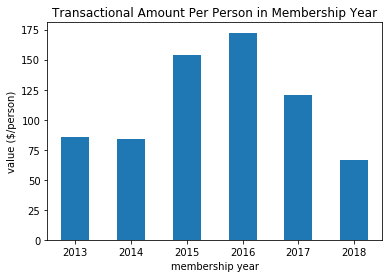

In [130]:
graph_spent_per_person_per_group(df2_null,'membership_year','membership year','Transactional Amount Per Person in Membership Year')

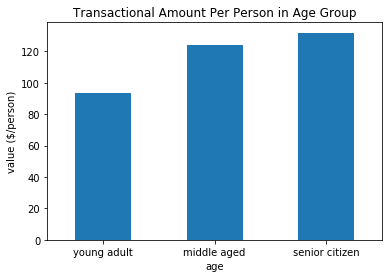

In [131]:
graph_spent_per_person_per_group(df2_null,'age_binned','age','Transactional Amount Per Person in Age Group')

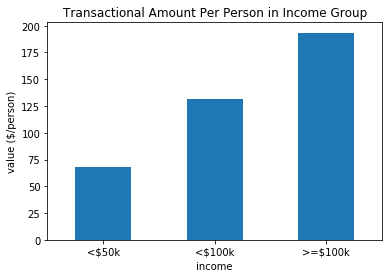

In [132]:
graph_spent_per_person_per_group(df2_null,'income_binned','income','Transactional Amount Per Person in Income Group')

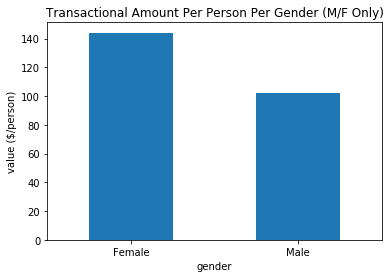

In [133]:
graph_spent_per_person_per_group(df2_null_mf,'gender','gender','Transactional Amount Per Person Per Gender (M/F Only)')